In this notebook, we will use Gated Recurrent Unit RNN to develop a time series forecasting model.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temparature, dewpoint and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import datetime

In [2]:
#Set current directory and work relative to it
os.chdir('E:/gitlab/project_on_python/deep time series forcasting/Practical-Time-Series-Analysis-master')

In [3]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')

In [4]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 13)


In [5]:
#Let's see the first five rows of the DataFrame
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [6]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

<IPython.core.display.Javascript object>


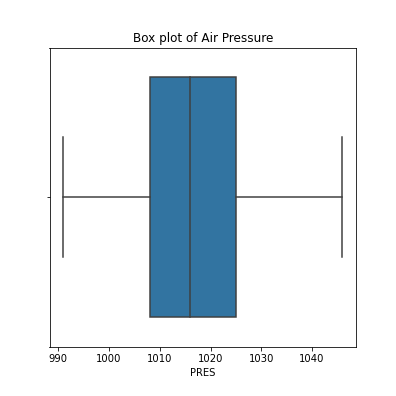

Text(0.5, 1.0, 'Box plot of Air Pressure')

In [26]:
#Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')
plt.show()

<IPython.core.display.Javascript object>


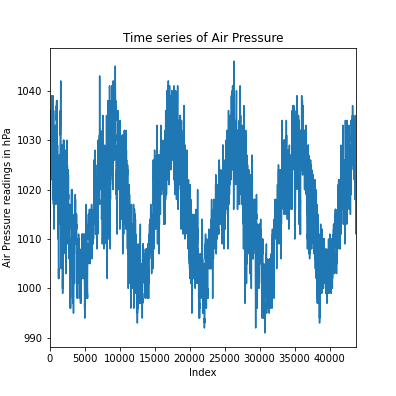

In [27]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure readings in hPa')
plt.show()

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. The PRES variable is minmax scaled as shown in the following cell in order to bound the scaled features within [0, 1].

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not neccesarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [8]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
Jan 1st, 2010 to Dec 31st, 2014. The first fours years - 2010 to 2013 is used as train and
2014 is kept for validation.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [9]:
#First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [10]:
#First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
35064,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
35065,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
35066,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
35067,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
35068,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


In [11]:
#Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>


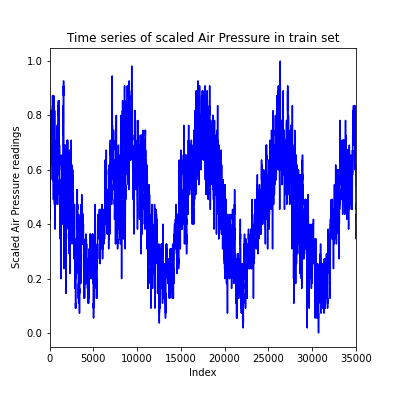

<IPython.core.display.Javascript object>


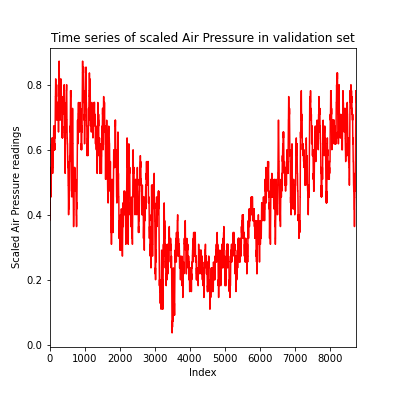

In [34]:
"""
The train and validation time series of standardized PRES is also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Time series of scaled Air Pressure in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')
# plt.show()

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Time series of scaled Air Pressure in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')
plt.show()

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm scaled_PRES in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [12]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [13]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [14]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8753, 7) (8753,)


The input to RNN layers must be of shape (number of samples, number of timesteps, number of features per timestep). In this case we are modeling only pm2.5 hence number of features per timestep is one. Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays.

In [15]:
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_val.shape)

Shape of 3D arrays: (35057, 7, 1) (8753, 7, 1)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')

In [18]:
#LSTM layer is defined for seven timesteps
gru_layer = GRU(64, input_shape=(7,1), return_sequences=False)(input_layer)

In [19]:
dropout_layer = Dropout(0.2)(gru_layer)

In [20]:
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. Mean square error (mse) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [21]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mse', optimizer='adam')
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
ts_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [22]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights_at = os.path.join('Chapter05\keras_models\PRSA_data_Air_Pressure_GRU_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq="epoch")
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 55s 2ms/sample - loss: 0.0019 - val_loss: 1.9706e-048s - l - ETA: 7s - l - -
Epoch 2/20
35057/35057 [==============================] - 47s 1ms/sample - loss: 6.1525e-04 - val_loss: 1.6936e-04
Epoch 3/20
35057/35057 [==============================] - 48s 1ms/sample - loss: 3.7506e-04 - val_loss: 1.5541e-04
Epoch 4/20
35057/35057 [==============================] - 39s 1ms/sample - loss: 3.2708e-04 - val_loss: 1.5695e-04
Epoch 5/20
35057/35057 [==============================] - 10s 286us/sample - loss: 3.1697e-04 - val_loss: 1.4714e-04
Epoch 6/20
35057/35057 [==============================] - 10s 277us/sample - loss: 3.1807e-04 - val_loss: 1.7505e-04
Epoch 7/20
35057/35057 [==============================] - 9s 253us/sample - loss: 3.1987e-04 - val_loss: 1.3837e-04
Epoch 8/20
35057/35057 [==============================] - 8s 241us/sample - loss: 3.1260e-04 - val_loss: 1.5789e-04
Epoch

Prediction are made for the air pressure from the best saved model. The model's predictions, which are on the minmax scaled  air-pressure, are inverse transformed to get predictions on original air pressure. The goodness-of-fit, R-squared is also calculated for the predictions on the original variable.

In [24]:
best_model = load_model(os.path.join('Chapter05\keras_models\PRSA_data_Air_Pressure_GRU_weights.18-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [25]:
from sklearn.metrics import r2_score
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('R-squared on validation set of the original air pressure:', r2)

R-squared on validation set of the original air pressure: 0.9957525099603557


<IPython.core.display.Javascript object>


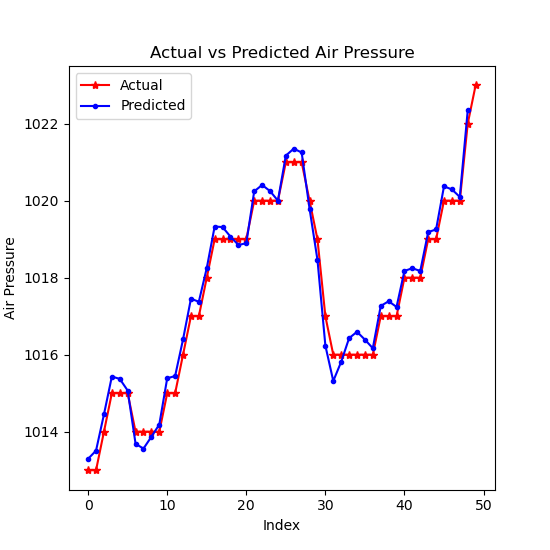

Text(0.5, 0, 'Index')

In [27]:
#Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(49), pred_PRES[1:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')